# Chapter 7

## 7.1 The problem with parameters
## 7.2 Accuracy and Entropy
## 7.3 Regularization
## 7.4 Predicting Predictive Accuracy
## 7.5 Model comparison

## Intro
+ OKHAM'S RAZOR - Models with fewer assumptions are to be preferrred
+ Have to tradeoff between model simplicity and model accuracy
+ OVERFITTING - poor prediction from over-learning the data
+ UNDERFITTING - Poor prediction by under-learning the data
+ Confounded models can produce better predictions than correct causal models.
+ In designing a model, we need to choose between understanding causes, and just predicting
+ But a causal model can suffer from over/underfitting
+ Two approaches to trading off under/overfitting
    + REGULARIZING PRIOR - Tighter priors?
    + Score using INFORMATION CRITERIA or CROSS-VALIDATION
    + probably use both approaches
    + Information Criteria is based on INFORMATION THEORY
+ lecture 7 Link
    + https://www.youtube.com/watch?v=odGAAJDlgp8

In [2]:
suppressMessages({
library(rethinking)
library(dagitty)
    })

# The problem with Parameters
+ Regress brain volume on mass (body) using increasing degrees of polynomials (starting at 1 degree - straight line)
+ 'Fit' of a model is assessed by a metric such as $R^2$ where:
    + $R^2 = \frac{var(outcome) - var(residuals)}{var(outcome} = 1 - \frac{var(residuals}{var(outcome}$
+ $R^2$ can be considered the proportion of variance 'explained' by the model
+ For $R^2$ bigger is better
+ This means some proportion of the total variation in the outcome data belongs to the model, and the rest is the variation of the residuals. 
+ $R^2$ is predicted at the mean of the prediction, not by considering the whole posterior distribution. This is problematic because the distribution may be skewed. This is lost by just using the mean prediction
+ An alternative Bayesian score is introduced later - XXXX - It uses the whole distribution 

In [3]:
# Setup a function to calculate R squared
## R code 7.6
R2_is_bad <- function( quap_fit ) {
    s <- sim( quap_fit , refresh=0 )
    r <- apply(s,2,mean) - d$brain_std
    1 - var2(r)/var2(d$brain_std)
}

In [4]:
## R code 7.1
sppnames <- c( "afarensis","africanus","habilis","boisei",
    "rudolfensis","ergaster","sapiens")
brainvolcc <- c( 438 , 452 , 612, 521, 752, 871, 1350 )
masskg <- c( 37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5 )
d <- data.frame( species=sppnames , brain=brainvolcc , mass=masskg )
str(d)

'data.frame':	7 obs. of  3 variables:
 $ species: chr  "afarensis" "africanus" "habilis" "boisei" ...
 $ brain  : num  438 452 612 521 752 871 1350
 $ mass   : num  37 35.5 34.5 41.5 55.5 61 53.5


In [5]:
## R code 7.2
# Standardize mass
d$mass_std <- (d$mass - mean(d$mass))/sd(d$mass)
# Scale mass to the maximum value - we want to maintain 0 as a reference point
d$brain_std <- d$brain / max(d$brain)
head(d, 20)

,species,brain,mass,mass_std,brain_std
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,afarensis,438,37.0,-0.7794667,0.3244444
2,africanus,452,35.5,-0.9170196,0.3348148
3,habilis,612,34.5,-1.0087216,0.4533333
4,boisei,521,41.5,-0.3668079,0.3859259
5,rudolfensis,752,55.5,0.9170196,0.5570370
6,ergaster,871,61.0,1.4213804,0.6451852
7,sapiens,1350,53.5,0.7336157,1.0000000


+ Initial linear model
    + $b_i \sim Normal(\mu_i, \sigma)$
    + $\mu_i = \alpha + \beta \times m_i$
    + Note - More complex models may look like
        + $\mu_i = \alpha + \beta_1 \times m_i + \beta_2 \times m_i^2 ... + \beta_n \times m_i^n$
    + $\alpha \sim Normal(0.5, 1)$
    + $\beta \sim Normal(0, 10)$
    + $\sigma \sim LogNormal(0, 1)$
+ These priors are prettty loose. Allow alot of scope
+ Model as code:

In [6]:
## R code 7.3
m7.1 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ), # exp(log_sigma) means the likelihood result is always greater than zero
        mu <- a + b*mass_std,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d )

+ Rethinking: OLS and Bayesian anti-essentialism - Cannot follow this section
+ For the first - linear model, calculate r^2 manually

In [7]:
## R code 7.5
set.seed(12)
s <- sim( m7.1 )
r <- apply(s,2,mean) - d$brain_std
resid_var <- var2(r)
outcome_var <- var2( d$brain_std )
1 - resid_var/outcome_var

[1] 0.477459

+ Higher order polynomial models

In [8]:
## R code 7.7
m7.2 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,2)) )

## R code 7.8
m7.3 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,3)) )

m7.4 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3 + b[4]*mass_std^4,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,4)) )

m7.5 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3 + b[4]*mass_std^4 +
                  b[5]*mass_std^5,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,5)) )

## R code 7.9
m7.6 <- quap(
    alist(
        brain_std ~ dnorm( mu , 0.001 ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3 + b[4]*mass_std^4 +
                  b[5]*mass_std^5 + b[6]*mass_std^6,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 )
    ), data=d , start=list(b=rep(0,6)) )

+ Plot of first order polynomial model fitted to 7 data points

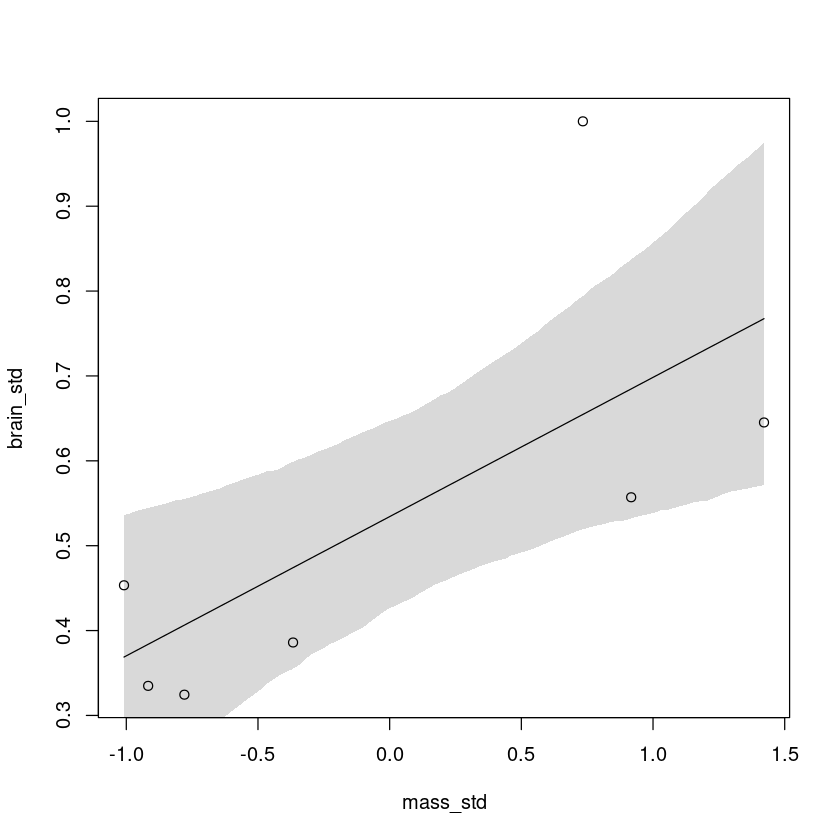

In [9]:
## R code 7.10
post <- extract.samples(m7.1)
mass_seq <- seq( from=min(d$mass_std) , to=max(d$mass_std) , length.out=100 )
l <- link( m7.1 , data=list( mass_std=mass_seq ) )
mu <- apply( l , 2 , mean )
ci <- apply( l , 2 , PI )
plot( brain_std ~ mass_std , data=d )
lines( mass_seq , mu )
shade( ci , mass_seq )

+ Plot of `n` order polynomial models fitted to the data where:
    + m7.1 - first order
    + m7.2 - second order
    + ...
    + m7.6 - sixth order
+ As model becomes more complex, model fits data better, and $R^2$ score improves - the model explains more of the variance
+ Black line is posterior mean
+ 89% interval is shaded
+ The six degree polynomial fits the data perfectly because it assigns each parameter to each data point
+ The lower degree polynomials are terrible fits

![alt text](images/7/overfitting-1.png "Title")

+ ### Leave One Out Process
+ Drop one row of the data
+ Fit the model
+ The most complex model swings about significantly.
+ The simplest model hardly moves

![alt text](images/7/overfitting-2.png "Title")

+ Bias and Variance - The tradeoff between under/overfitting. Not exactly the same, but
    + Bias relates to underfitting
    + Variance relates to Overfitting

# 7.2 Entropy and Accuracy

+ To score a Bayesian Analysis, we use the LOG SCORING RULE to assess how closely a model predicts probabilities compared to true probabilities - This is the log of the joint probability , where the joint probability is considered the likelihood. We can use this to compare models.
+ We use a measure of how much uncertainty is inherent in a probability distribution. This is the INFORMATION ENTROPY
    + $H(p) = -E \; log(p_i) = -\sum_{i=1}^n p_ilog(p_i)$
+ To assess how far away we are from perfect prediction, we use a divergence score - the Kullback-Leibler divergence, or KL divergence score.from a perfect score, 
+ [???? - This is a really convoluted section. Maybe author should start with conclusion and build an argument to get there. I am having trouble deciphering where the author finally lands - ie what scoring formula to use]
+ As far as I can tell, the author uses the following to score a model:
    + **LOG-POINTWISE-PREDICTIVE-DENSITY**
    + $lppd(y, \theta) = \sum_{i} log \frac{1}{S} \sum_S p(y_i | \theta_s)$
    + where:
        + $S$ is number of samples
        + $\theta_S$ is the posterior distribution
+ For the lppd, bigger is better
+ There is another formulation of lppd called DEVIANCE
    + $DEVIANCE = -2 \times lppd score$
    + For Deviance - smaller is better
+ To calculate the lppd scores in code:

In [10]:
## R code 7.13
set.seed(1)
lppd( m7.1 , n=1e4 )

[1]  0.6098721  0.6483495  0.5496133  0.6234983  0.4648174  0.4347638 -0.8444714

+ Or, laying out the code for the lppd calculation
+ These should be summed, though christ knows why the author wouldn't just sum them here in code

In [11]:
## R code 7.14
set.seed(1)
logprob <- sim( m7.1 , ll=TRUE , n=1e4 )
n <- ncol(logprob)
ns <- nrow(logprob)
f <- function( i ) log_sum_exp( logprob[,i] ) - log(ns)
( lppd <- sapply( 1:n , f ) )

[1]  0.6098721  0.6483495  0.5496133  0.6234983  0.4648174  0.4347638 -0.8444714

## Training and Test Set
+ Now that we have developed a score, we need to make sure we apply it to the correct part of the data
+ If we score the models as set up previously we get as below
+ But, this is irrelevant - What matters is how we score on unseen data

In [12]:
## R code 7.15
set.seed(1)
sapply( list(m7.1,m7.2,m7.3,m7.4,m7.5,m7.6) , function(m) sum(lppd(m)) )

[1]  2.490409  2.566165  3.741488  5.333750 14.124459 39.445390

+ The author runs a simulation to show how in-sample and out-of-sample deviance scores are impacted by parameters
+ The simulation is set up so that the data is generated from a 3 parameter function. Hence the 'correct' number of parameters is 3
+ N is the size of the training and test sample - 20 each, or 100 each
+ I don't get why he is calling this a deviance score - It is
    + $-2 \times lppd$

In [13]:
# Cannot get this to run !!
# Probably mcreplicate line
## R code 7.16
# N <- 20
# kseq <- 1:5
# dev <- sapply( kseq , function(k) {
#         print(k);
#         r <- mcreplicate( 1e4 , sim_train_test( N=N, k=k ) , mc.cores=4 )
#         c( mean(r[1,]) , mean(r[2,]) , sd(r[1,]) , sd(r[2,]) )
#     } )

In [14]:
# Cannot get code above to run, so this plot is defunct !!
## R code 7.18
# plot( 1:5 , dev[1,] , ylim=c( min(dev[1:2,])-5 , max(dev[1:2,])+10 ) ,
#     xlim=c(1,5.1) , xlab="number of parameters" , ylab="deviance" ,
#     pch=16 , col=rangi2 )
# mtext( concat( "N = ",N ) )
# points( (1:5)+0.1 , dev[2,] )
# for ( i in kseq ) {
#     pts_in <- dev[1,i] + c(-1,+1)*dev[3,i]
#     pts_out <- dev[2,i] + c(-1,+1)*dev[4,i]
#     lines( c(i,i) , pts_in , col=rangi2 )
#     lines( c(i,i)+0.1 , pts_out )
# }

![alt text](images/7/simulate-in-out-sample-scores.png "Title")

+ The conclusion of this is that the lowest out-of-sample Deviance is associated, in both scenarios - 20 or 100 sample size, with the 'correct' number of parameters - where 'correct' means the number of parameters that were used to generate the data

# 7.3 Regularization

![alt text](images/7/regularizing-priors.png "Title")

### Impact of REGULARIZING PRIORS
+ [If I interpreted this correctly, the author states that priors can be tuned to be more or less regularizing based on model performance. Maybe I have misunderstood, but this seems like a sneaky way of using the data to set the priors, without actually looking at the data?]
+ Run an experiment building and running linear models
    + The model looks like:
        + $b_i \sim Normal(\mu_i, \sigma)$
        + $\mu_i = \alpha + \beta \times m_i$
        + Note - More complex models may look like
            + $\mu_i = \alpha + \beta_1 \times m_i + \beta_2 \times m_i^2 ... + \beta_n \times m_i^n$
        + $\alpha \sim Normal(0.5, 1)$
        + $\beta \sim Normal(0, 10)$
        + $\sigma \sim LogNormal(0, 1)$
    + The model used standardized data, so the predictor x is 0 centered and has standard deviation = 1
    + If the $\beta$ parameter is set to 1, this means there is only a 5% (prior) plausibilty that it will be set to 2 standard deviations away from 0 (Because 95% probability is contained within +/- 2 standard deviations for a normal distribution). This is like saying that a change in 1 stdev of the predictor would lead to a 2 stdev change in the outcome.
    + Conduct an experiment where 3 things vary in each run:
        + The number of parametrs. The linear part of the model can look like:
            + $\mu_i = \alpha + \beta_1 \times m_i$ - First Order polynomial
            + ...
            + $\mu_i = \alpha + \beta_1 \times m_i + \beta_2 \times m_i^2 ... + \beta_5 \times m_i^n$ - Fifth Order polynomial
        + Change the priors. The priors can look like (See the picture above):
            + Weak Prior: $\beta_n \sim Normal(0,1)$. Also called Flat prior - Unopinionated - Relaxes the model fit
            + Strong Prior: $\beta_n \sim Normal(0, 0.5)$ Also called [weak? - not sure what he calls this]
            + Regularizing Prior: $\beta_n \sim Normal(0, 0.2)$ Also clled skeptical prior - Constrains the model
        + Change the data sample size:
            + N = 20
            + N = 100
    + Measure the result of each run using the DEVIANCE metric (Smaller is better)
        + On the training data - the data used to fit the model
        + On the test data - data that the model has never seen before
            
![alt text](images/7/reg-priors-out-of-sample-deviance.png "Title")

+ Experiment Results:
    + Left Hand Plot - sample size = 20
        + The training scores (blue) continue to improve as more parameters are added to the model. The model overfits.
        + The test scores (black) are always worse than the training scores
        + The test scores (black) are best at 3 parameters (This was the number of parameters used to generate the original data - see above)
        + For the training data (blue):
            + The flattest prior $Normal(0,1)$ - dashed line - allows the model to overfit more than the regularization (tight) prior $Normal(0, 0.2)$ - bold line. 
        + We are most interested in the test data (black) results because this gives an indication as to how the model will perform if we use it in the world. For the test data:
            + The flattest prior $Normal(0, 1)$ - dashed line - scores worse than the regularized prior $Normal(0, 0.2)$ - bold line. So the harm done by a higher number of parameters (more complex model) is reduced by using a tighter (regularized) prior.
            + So, for small data the worst performing model (in terms of prior setting) on training data is the best performing model on the test data. Wow!
    + Right Hand Plot - sample size = 100
        + All the lines are closer together. This means regardless of the how the prior is set - flat or regularized, the volume of data tends to wash out the impact of the priors on the final model performance.

# 7.4 Predicting Predictive Accuracy - [TODO - Struggling to understand this section]

### Simulation Setup

+ We have 3 ways of assessing performance:
    + Cross Validation - LEAVE ONE OUT CROSS VALIDATION (LOOCV)
    + PSIS - PARETO SMOOTHED IMPORTANCE SAMPLING CROSS VALIDATION
    + WAIC - WIDELY APPLICABLE INFORMATION CRITERION
+ We run a simulation to assess how these methods compare in assessing model performance.
+ We use data that is generated from a function with 3 parameters.

+ Run an experiment building and running linear models - similar to previous simulation setups
    + The model looks like:
        + $b_i \sim Normal(\mu_i, \sigma)$
        + $\mu_i = \alpha + \beta \times m_i$
        + Note - More complex models may look like
            + $\mu_i = \alpha + \beta_1 \times m_i + \beta_2 \times m_i^2 ... + \beta_n \times m_i^n$
        + $\alpha \sim Normal(0.5, 1)$
        + $\beta \sim Normal(0, 10)$
        + $\sigma \sim LogNormal(0, 1)$
    + The model used standardized data, so the predictor x is 0 centered and has standard deviation = 1
    + If the $\beta$ parameter is set to 1, this means there is only a 5% (prior) plausibilty that it will be set to 2 standard deviations away from 0 (Because 95% probability is contained within +/- 2 standard deviations for a normal distribution). This is like saying that a change in 1 stdev of the predictor would lead to a 2 stdev change in the outcome.
    + Conduct an experiment where 3 things vary in each run:
        + The number of parametrs. The linear part of the model can look like:
            + $\mu_i = \alpha + \beta_1 \times m_i$ - First Order polynomial
            + ...
            + $\mu_i = \alpha + \beta_1 \times m_i + \beta_2 \times m_i^2 ... + \beta_5 \times m_i^n$ - Fifth Order polynomial
        + Change the priors. The priors can look like (See the picture above):
            + Flat Prior: $\beta_n \sim Normal(0,1)$. Also called Flat prior - Unopinionated - Relaxes the model fit
            + Regularizing Prior: $\beta_n \sim Normal(0, 0.2)$ Also clled skeptical prior - Constrains the model
        + Change the data sample size:
            + N = 20
            + N = 100
    + Measure the result of each run using the average deviance metric (Smaller is better)
        + On the test data - data that the model has never seen before
    + Measurement Methods are (definitions come below):
        + Cross Validation
        + PSIS
        + WAIC

![alt text](images/7/waic-1.png "Title")

+ [ Finding this really difficult to interpret - Cannot understand how this plot is put together - Even worse, I am not 100% sure what I am supposed to take away from this - I think it is:
    + **To prevent overfitting, and perform better on out-of-sample data - Use regularized priors and measure deviance with PSIS, or WAIC, because these two (inexpensive) methods give similar results to the expensive LOOCV method (I think?)**
+ Top Left Hand Plot
    + The top 3 lines are for a flat (relaxed) prior, the bottom 3 lines are for regularized priors
    + The unfilled dots are the average deviance for flat priors
    + The filled dots are the average deviance for regularized priors
    + The scale for the lines is absolute deviance (even though the axis is labelled average deviance)
+ [Cannot follow this section]

In [15]:
## R code 7.19
data(cars)
m <- quap(
    alist(
        dist ~ dnorm(mu,sigma),
        mu <- a + b*speed,
        a ~ dnorm(0,100),
        b ~ dnorm(0,10),
        sigma ~ dexp(1)
    ) , data=cars )
set.seed(94)
post <- extract.samples(m,n=1000)

## R code 7.20
n_samples <- 1000
logprob <- sapply( 1:n_samples ,
    function(s) {
        mu <- post$a[s] + post$b[s]*cars$speed
        dnorm( cars$dist , mu , post$sigma[s] , log=TRUE )
    } )

## R code 7.21
n_cases <- nrow(cars)
lppd <- sapply( 1:n_cases , function(i) log_sum_exp(logprob[i,]) - log(n_samples) )

## R code 7.22
pWAIC <- sapply( 1:n_cases , function(i) var(logprob[i,]) )

## R code 7.23
-2*( sum(lppd) - sum(pWAIC) )

## R code 7.24
waic_vec <- -2*( lppd - pWAIC )
sqrt( n_cases*var(waic_vec) )

[1] 423.3188

[1] 17.81797

# 7.5 Model Comparison

+ Instead of Model Selection, consider MODEL COMPARISON. We do not want just just select the best performing model, because the other models can also give us information. The information could be the gap in performance between the beset and second best performing model, or [I guess] difference between families of models. We also may have a sitution where we need to realte the model to causal inference. We know that the best predicting model may not be the best model to infer how an intervention will work.
+ The tools we use for model comparison are:
    + A variety of models to compare built with different structures
    + Regularizing priors - These tend to reduce in-sample performance, but improve predictions on unseen data
    + Measures of Predictive Ability such as Leave One Out cross validation (LOOCV, or CV), Pareto smoothed Importance Sampling (PSIS) and Widely Applicable Information Criterion (WAIC) These measure the expected predictive value of a [variable - Why variable? does this mean model?], accounting for overfitting. They  assess model overfitting. They may help in designing models. I guess the score feedsback into model design.
+ Inferring cause and making predictions are different tasks. The test of a good causal model is whether we can reasonably predict the results of an intervention, not whether it has a good WAIC score. 
    
### 7.5.1 Model Mis-Selection
+ Going back to the fungus model in Chapter 6
    + We split N plants into treatment and control groups. On day 0 we measure all the plants $H_0$ and apply an anti-fungal treatment $T$ to the treatment plants. At day i we re-measure all the plants $H_1$, and assess whether each plant has fungus $F$ (Yes/No)
    + Fungus presence is a POST TREATMENT VARIABLE
    + The causal model as proposed in chapter 6 is below - this is model `m6.8`
    + The model that includes the fungus as a predictor is `m6.7` I think I would know this as DATA LEAKAGE. We are using data from the future to predict something about the future.

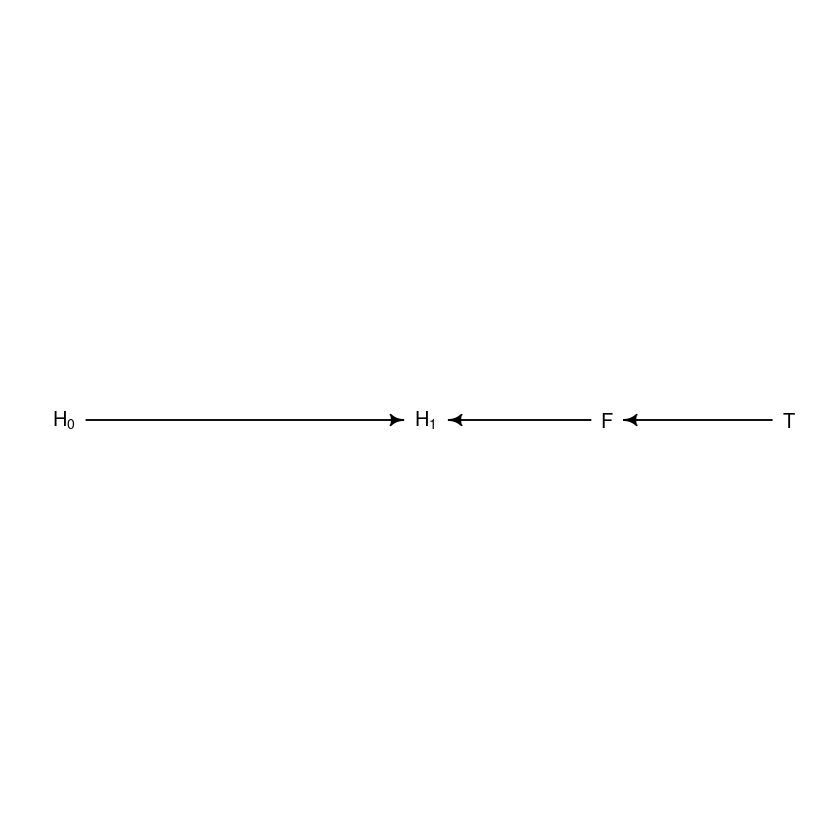

In [17]:
# R code 6.18
plant_dag <- dagitty( "dag {
    H_0 -> H_1
    F -> H_1
    T -> F}")
coordinates( plant_dag ) <- list( x=c(H_0=0,T=2,F=1.5,H_1=1) , y=c(H_0=0,T=0,F=0,H_1=0) )
drawdag(plant_dag)

In [18]:
# Code from last chapter used as models in this chapter
## R code 6.13
set.seed(71)
# number of plants
N <- 100

# simulate initial heights
h0 <- rnorm(N,10,2)

# assign treatments and simulate fungus and growth
treatment <- rep( 0:1 , each=N/2 )
fungus <- rbinom( N , size=1 , prob=0.5 - treatment*0.4 )
h1 <- h0 + rnorm(N, 5 - 3*fungus)

# compose a clean data frame
d <- data.frame( h0=h0 , h1=h1 , treatment=treatment , fungus=fungus )
precis(d)

## R code 6.14
sim_p <- rlnorm( 1e4 , 0 , 0.25 )
precis( data.frame(sim_p) )

## R code 6.15
m6.6 <- quap(
    alist(
        h1 ~ dnorm( mu , sigma ),
        mu <- h0*p,
        p ~ dlnorm( 0 , 0.25 ),
        sigma ~ dexp( 1 )
    ), data=d )
precis(m6.6)

## R code 6.16
m6.7 <- quap(
    alist(
        h1 ~ dnorm( mu , sigma ),
        mu <- h0 * p,
        p <- a + bt*treatment + bf*fungus,
        a ~ dlnorm( 0 , 0.2 ) ,
        bt ~ dnorm( 0 , 0.5 ),
        bf ~ dnorm( 0 , 0.5 ),
        sigma ~ dexp( 1 )
    ), data=d )
precis(m6.7)

## R code 6.17
m6.8 <- quap(
    alist(
        h1 ~ dnorm( mu , sigma ),
        mu <- h0 * p,
        p <- a + bt*treatment,
        a ~ dlnorm( 0 , 0.2 ),
        bt ~ dnorm( 0 , 0.5 ),
        sigma ~ dexp( 1 )
    ), data=d )
precis(m6.8)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
h0,9.95978,2.1011623,6.570328,13.07874,▁▂▂▂▇▃▂▃▁▁▁▁
h1,14.39920,2.6880870,10.618002,17.93369,▁▁▃▇▇▇▁▁
treatment,0.50000,0.5025189,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▇
fungus,0.23000,0.4229526,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▂


,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
sim_p,1.03699,0.2629894,0.670683,1.496397,▁▁▃▇▇▃▁▁▁▁▁▁


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
p,1.426626,0.01760992,1.398482,1.454770
sigma,1.793286,0.12517262,1.593236,1.993336


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.481391468,0.02451069,1.44221865,1.52056429
bt,0.002412222,0.02986965,-0.04532525,0.05014969
bf,-0.266718915,0.03654772,-0.32512923,-0.20830860
sigma,1.408797442,0.09862070,1.25118251,1.56641237


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.38035767,0.02517554,1.34012229,1.4205931
bt,0.08499924,0.03429718,0.03018573,0.1398128
sigma,1.74631655,0.12191552,1.55147200,1.9411611


In [19]:
## R code 7.25
set.seed(11)
WAIC( m6.7 )

WAIC,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
361.4511,-177.1724,3.553198,14.17033


,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6.7,361.8901,14.26190,0.00000,NA,3.839491,1.000000e+00
m6.8,402.7757,11.28257,40.88562,10.47837,2.645879,1.323732e-09
m6.6,405.9139,11.64641,44.02380,12.22582,1.581312,2.756471e-10


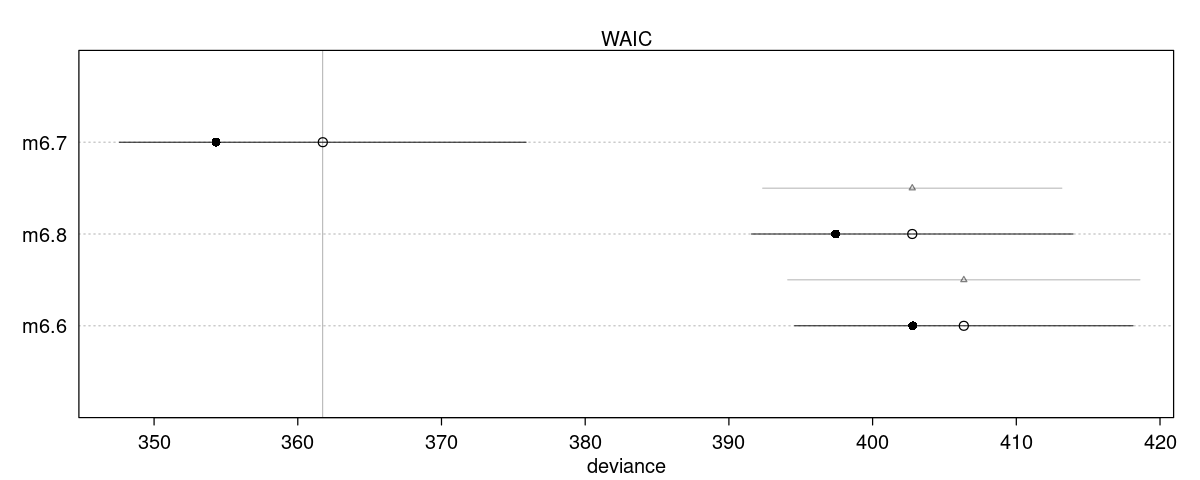

In [25]:
## R code 7.26
set.seed(77)
compare( m6.6 , m6.7 , m6.8 , func=WAIC )
options(repr.plot.width=10, repr.plot.height=4)
plot(compare( m6.6 , m6.7 , m6.8 , func=WAIC ))

+ Models in plot above:
    + `m6.6` - model of growth alone withot fungus or treatment WAIC 406 - Worst
    + `m6.8` - model of growth based on treatment WAIC 403
    + `m6.7` - model of growth from treatment AND fungus WAIC 361 - Best
+ Interpreting the output:
    + WAIC values - smaller is better
    + pWAIC - penalty term of WAIC - values close to number of dimensions in the posterior in each model
    + dWAIC - Difference between each model's WAIC and the best WAIC in the set. `m6.7` is 40 deviance units smaller than the next and `m6.8` is ~ 3deviance units smaller than `m6.6`. But these need to be interpreted along with the the standard error of WAIC - `SE` and the standard error of the deviance `dSE`
    + Note that with small samples, these values dramatically underestimate uncertainty, but we can still use them as scale approximations.
    + To calculate the standard error of the difference between `m6.7` and `m6.8` we do it like this: 

In [27]:
## R code 7.27
set.seed(91)
waic_m6.7 <- WAIC( m6.7 , pointwise=TRUE )$WAIC
waic_m6.8 <- WAIC( m6.8 , pointwise=TRUE )$WAIC
n <- length(waic_m6.7)
diff_m6.7_m6.8 <- waic_m6.7 - waic_m6.8
sqrt( n*var( diff_m6.7_m6.8 ) )

[1] 10.3581

In [28]:
## R code 7.28
40.0 + c(-1,1)*10.4*2.6

[1] 12.96 67.04

+ Reviewing the plot (duplicated below):
    + Black points are in-sample WAIC
    + Open points are out-of-sample WAIC
    + In-sample does better than out-of sample
    + Light lines with triangle is standard error of difference in WAIC between the models

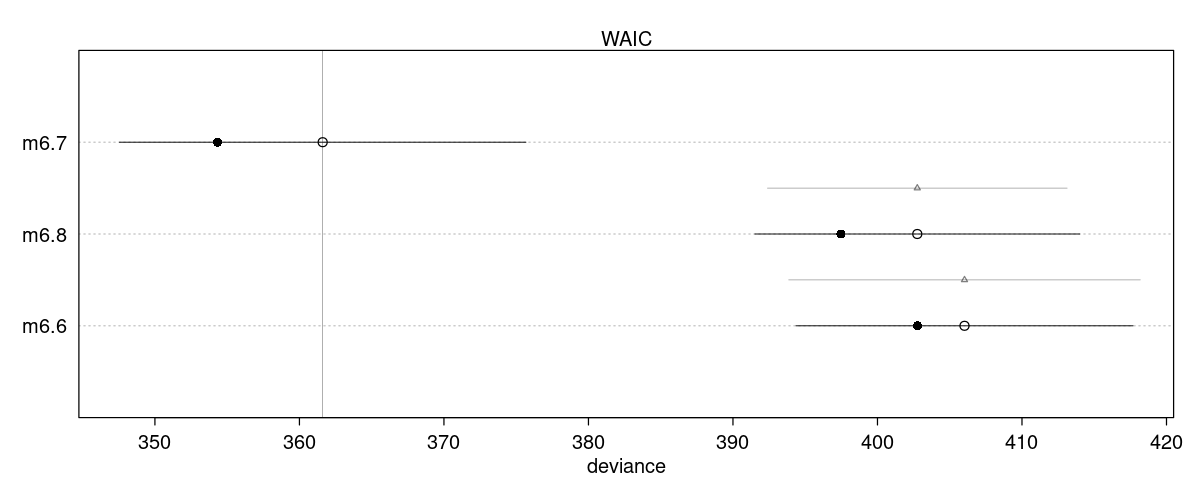

In [29]:
plot(compare( m6.6 , m6.7 , m6.8 , func=WAIC ))

In [ ]:
## R code 7.30
set.seed(92)
waic_m6.6 <- WAIC( m6.6 , pointwise=TRUE )$WAIC
diff_m6.6_m6.8 <- waic_m6.6 - waic_m6.8
sqrt( n*var( diff_m6.6_m6.8 ) )

## R code 7.31
set.seed(93)
compare( m6.6 , m6.7 , m6.8 )@dSE

+ Last column of table is `weight`. Used for MODEL AVERAGING 

+ Alternatively, using PSIS to compare - the numbers are just about the same as WAIC - Numbers & plot below

,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6.7,361.9879,14.35612,0.00000,NA,3.888397,1.000000e+00
m6.8,402.8104,11.34443,40.82255,10.49459,2.663248,1.366143e-09
m6.6,405.9343,11.70914,43.94642,12.24255,1.591529,2.865205e-10


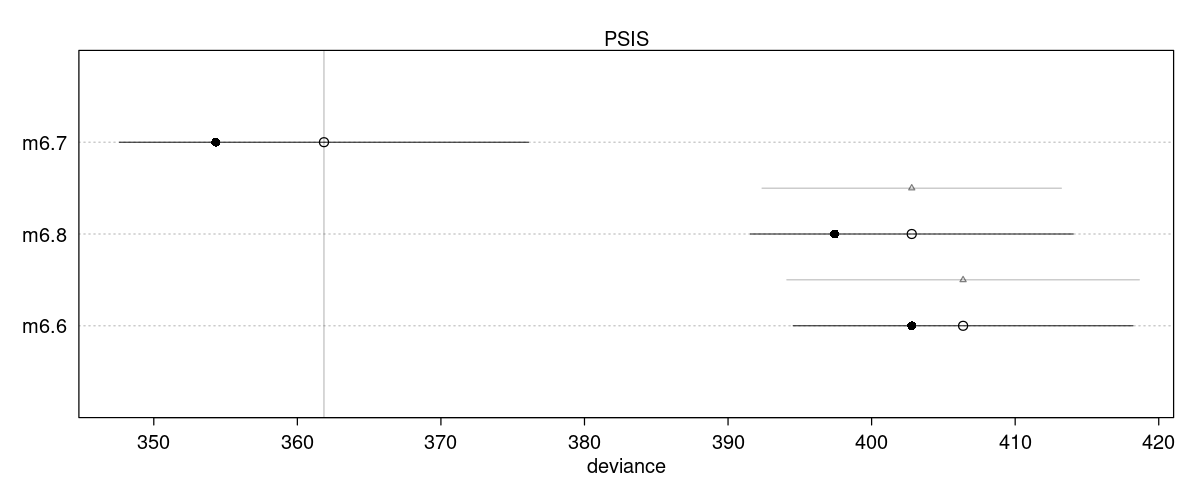

In [31]:
## 
set.seed(77)
compare( m6.6 , m6.7 , m6.8 , func=PSIS )
options(repr.plot.width=10, repr.plot.height=4)
plot(compare( m6.6 , m6.7 , m6.8 , func=PSIS ))

### 7.5.1 Outliers and Other Illusions
+ Outliers can be very influential in ordinary regression models
+ Demonstarte how PSIS and WAIC represent the importance o outliers
+ original waffle Divorce models re-created below
+ `m5.1` - $D \sim A$
+ `m5.2` - $D \sim M$
+ `m5.3` - $D \sim A + M$

In [32]:
## R code 7.32
library(rethinking)
data(WaffleDivorce)
d <- WaffleDivorce
d$A <- standardize( d$MedianAgeMarriage )
d$D <- standardize( d$Divorce )
d$M <- standardize( d$Marriage )

m5.1 <- quap(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + bA * A ,
        a ~ dnorm( 0 , 0.2 ) ,
        bA ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )

m5.2 <- quap(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + bM * M ,
        a ~ dnorm( 0 , 0.2 ) ,
        bM ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )

m5.3 <- quap(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + bM*M + bA*A ,
        a ~ dnorm( 0 , 0.2 ) ,
        bM ~ dnorm( 0 , 0.5 ) ,
        bA ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )

## R code 7.33
set.seed(24071847)
compare( m5.1 , m5.2 , m5.3 , func=PSIS )

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m5.1,127.9570,14.97838,0.000000,NA,4.889910,0.805205641
m5.3,130.8062,16.15698,2.849246,1.576107,6.578656,0.193731750
m5.2,141.2177,11.56540,13.260741,11.147320,4.057106,0.001062609


Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



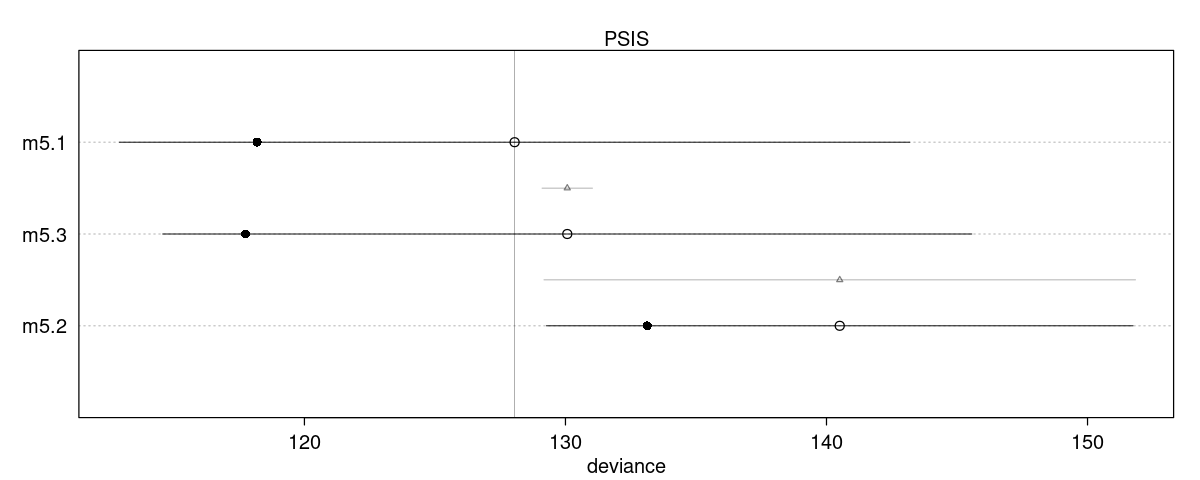

In [33]:
options(repr.plot.width=10, repr.plot.height=4)
plot(compare( m5.1 , m5.2 , m5.3 , func=PSIS ))

+ Ordered from best to worst score
+ `m5.1` - $D \sim A$ Divorce vs Age has the best score. Because marriage rate has very little association with Divorce, so this model has better out-of-sample performance
+ `m5.3` - $D \sim A + M$
+ `m5.3` - $D \sim A + M$
+ Difference between top 2 models is 1.8 with a standard error of 0.9, so both models are about the same.
+ Warning message `Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.` suggests some points may be outliers with unlikely values. This means they are very influential and may compromise out-of-sample accuracy. (Because new sample unlikely to contain these outliers)
+ To see which points are causing the warning us - PSIS with `pointwise=TRUE`

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



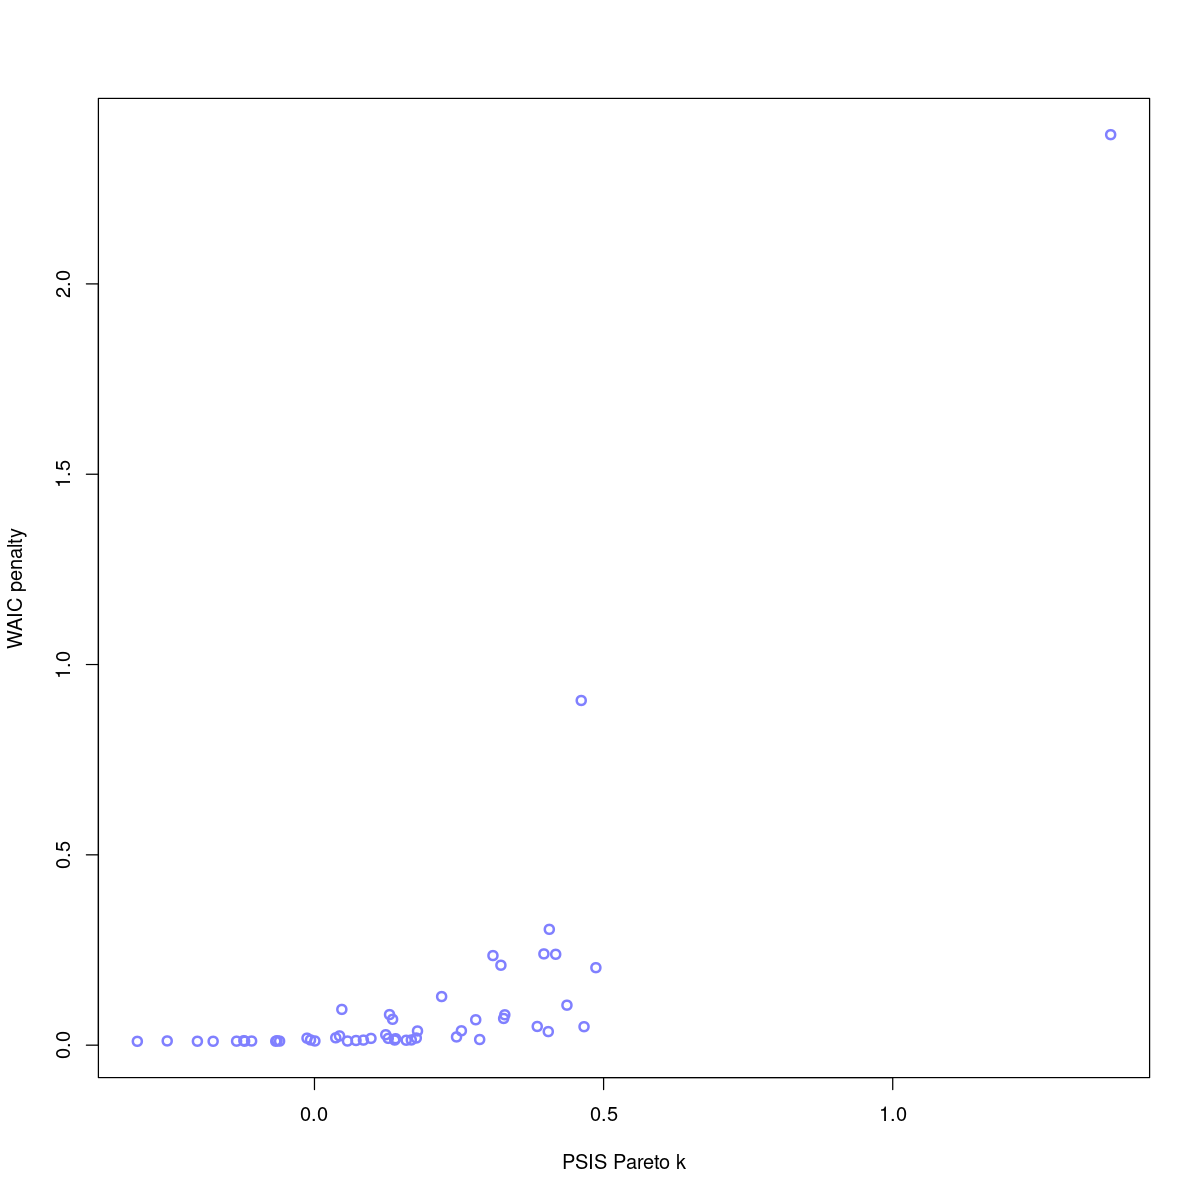

In [35]:

## R code 7.34
set.seed(24071847)
PSIS_m5.3 <- PSIS(m5.3,pointwise=TRUE)
set.seed(24071847)
WAIC_m5.3 <- WAIC(m5.3,pointwise=TRUE)
options(repr.plot.width=10, repr.plot.height=10)
plot( PSIS_m5.3$k , WAIC_m5.3$penalty , xlab="PSIS Pareto k" ,
    ylab="WAIC penalty" , col=rangi2 , lwd=2 )

+ Book version of plot below with Idaho & ME labelled:

![alt text](images/7/waic-5.3.png "Title")

+ Try not to drop outliers - especially before even fitting the model.
+ Can try model with and without outliers and compare
+ The outliers may be a manifestation of the normal distribution  used in the model. This has thin tails. Many real life distributions have fatter tails.
+ We may be able to overcome this through the ROBUST REGRESSION technique of using a STUDENT'S T DISTRIBUTION as the model distribution
+ This is a distribution that occurs where multiple normal distributions with different variances are mixed together.
+ The the variances are very far apart, the tails can be a bit fatter
+ The student's t distribution has 3 parameters
    + $\mu$ - mean
    + $\sigma$ - scale
    + $V$ - tail thickness parameter . Big $V$ means thin tails, small $V$ means fat tails
+ Comparison of distributions below:

![alt text](images/7/thin-tails.png "Title")

+ Rebuild the model with a student's t distribution with $V = 2$

In [38]:
## R code 7.35
m5.3t <- quap(
    alist(
        D ~ dstudent( 2 , mu , sigma ) ,
        mu <- a + bM*M + bA*A ,
        a ~ dnorm( 0 , 0.2 ) ,
        bM ~ dnorm( 0 , 0.5 ) ,
        bA ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )

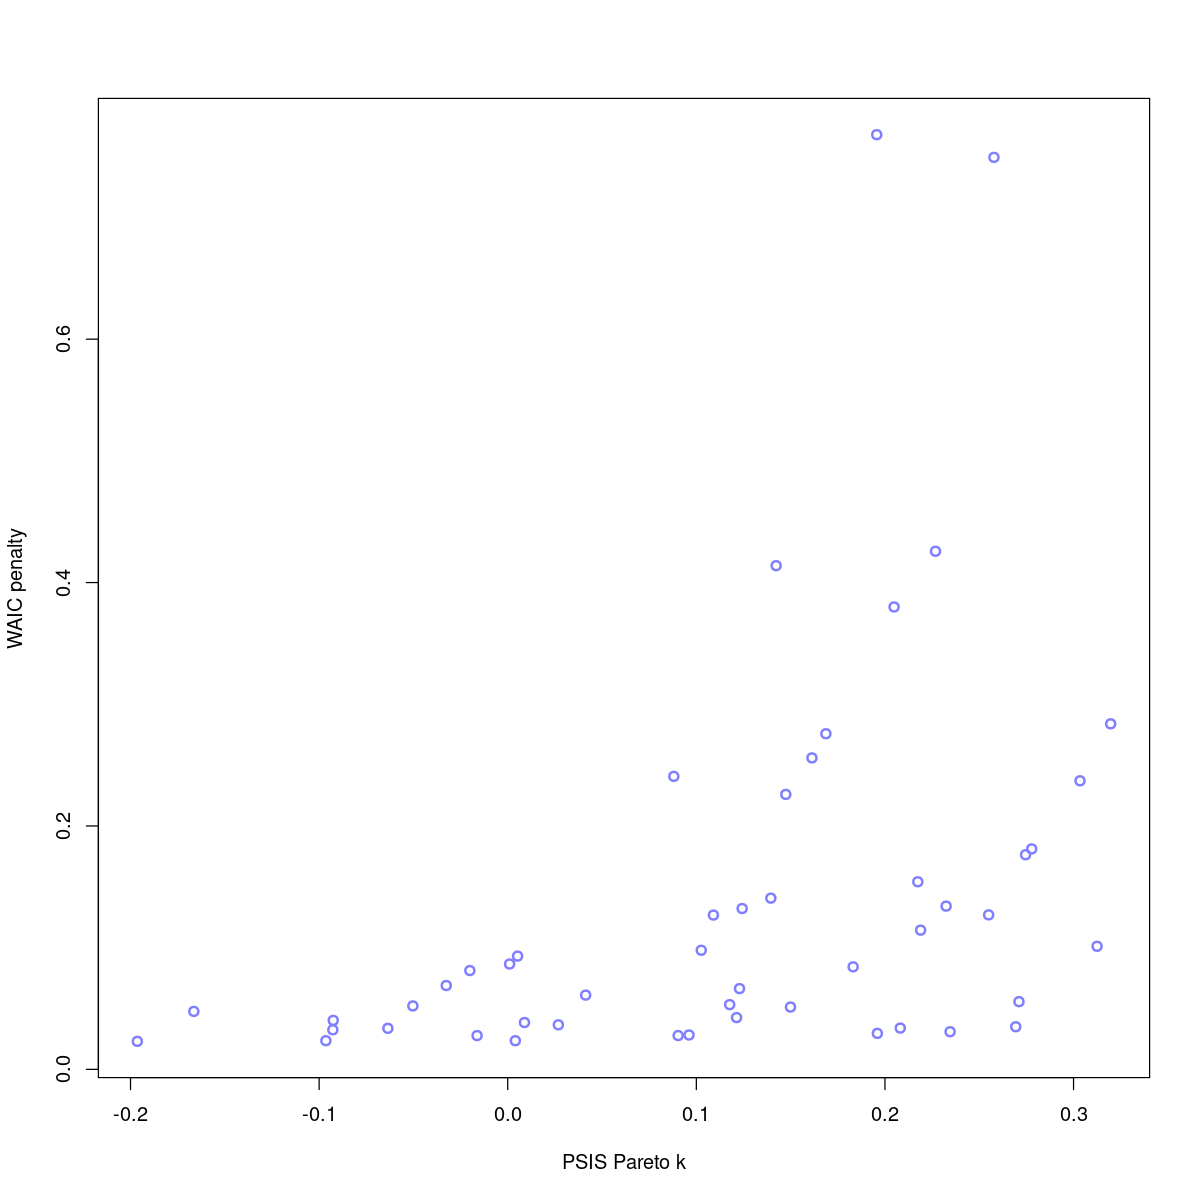

In [39]:
## R code 7.34
set.seed(24071847)
PSIS_m5.3t <- PSIS(m5.3t,pointwise=TRUE)
set.seed(24071847)
WAIC_m5.3t <- WAIC(m5.3t,pointwise=TRUE)
options(repr.plot.width=10, repr.plot.height=10)
plot( PSIS_m5.3t$k , WAIC_m5.3t$penalty , xlab="PSIS Pareto k" ,
    ylab="WAIC penalty" , col=rangi2 , lwd=2 )

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



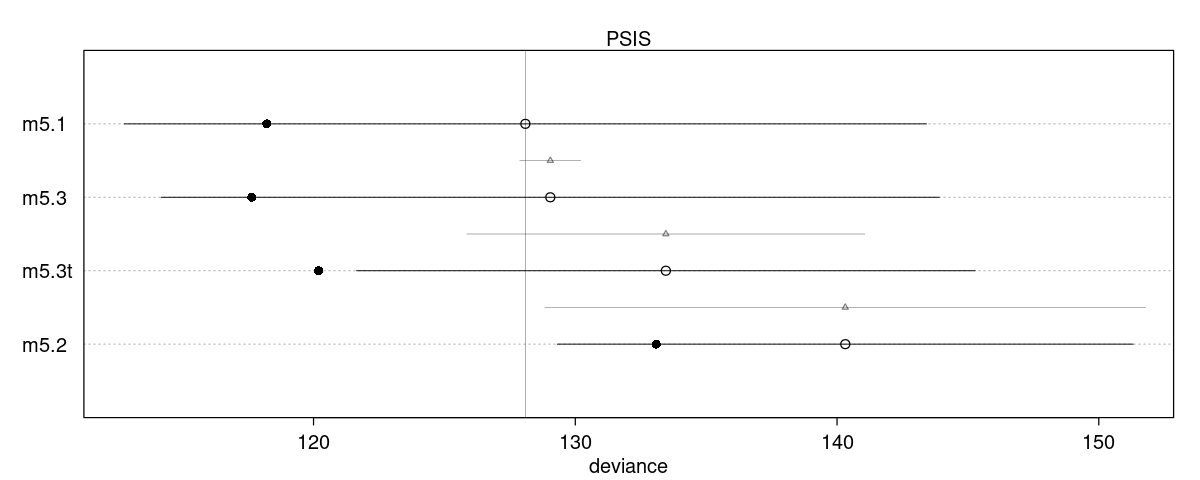

In [42]:
options(repr.plot.width=10, repr.plot.height=4)
plot(compare( m5.1 , m5.2 , m5.3, m5.3t, func=PSIS ))

In [43]:
 PSIS(m5.3t)

PSIS,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
133.8297,-66.91485,6.920336,11.94325
